# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle that contains information on 3 million used cars.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Used Car Business
**Used Car business is 100+ billion dollar industry, there is a huge market outside of USA too.** 
**Used car sales Dealership XYZ, has asked us to look at their sales data from 1909 to 2014 and to create a Price recommendation/prediction System.**


### Expected solution
**Price recommendation/prediction system should be based on a regression model which is trained on clean data with relavent features and it should have maximum accuracy in predicting prices.**

### Python to Rescue
**Python ML models are more advanced these days, Scikit-Learn python library is most used accros the industry. The data mining decisions will be made based on visualization and analysis.**


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [73]:
# Necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder,StandardScaler
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score,RandomizedSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel

from sklearn import set_config
set_config(display="diagram")

from warnings import filterwarnings
filterwarnings('ignore')
import missingno as msno

# Advanced Regression ensamble models
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [125]:
used_cars = pd.read_csv('data/vehicles.csv')
print(used_cars.info())
print('*************NAN value counts*************')
print(used_cars.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

**Data observation:** Total 17 columns, aproximately 400k+ rows, Othee than index: id, there are three numeric columns and 13 non-numeric columns. All the column values are not fully populated , I find null values and NANs in many columns. 

**Plotting using missingno library: to detrmine missing values**

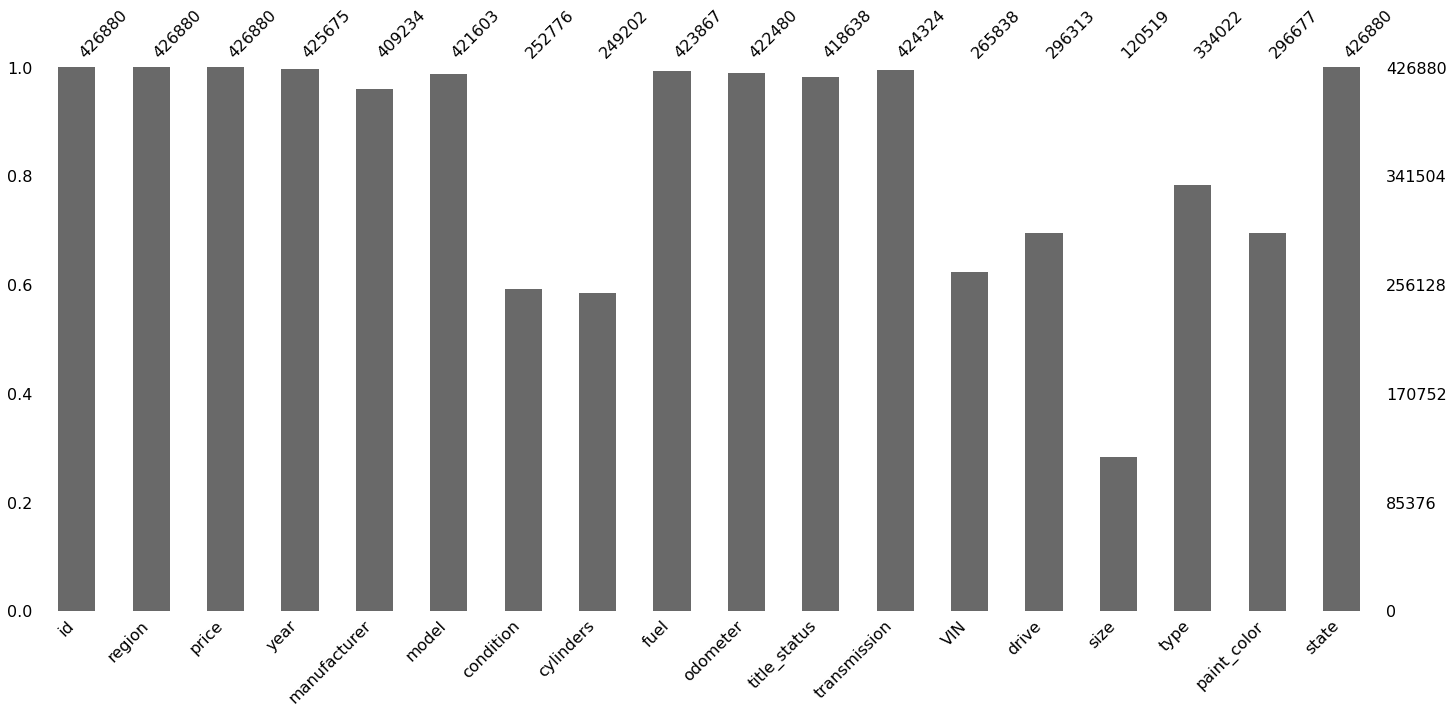

In [75]:
msno.bar(used_cars);

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

1.  **Drop column values with NANs**
2.  **Remove duplicates (if any)**
3.  **Resetting index of the dataframe**
4.  **Create a new 'age' column and drop 'year' column**
5.  **Drop all rows that have price as zero(0)**


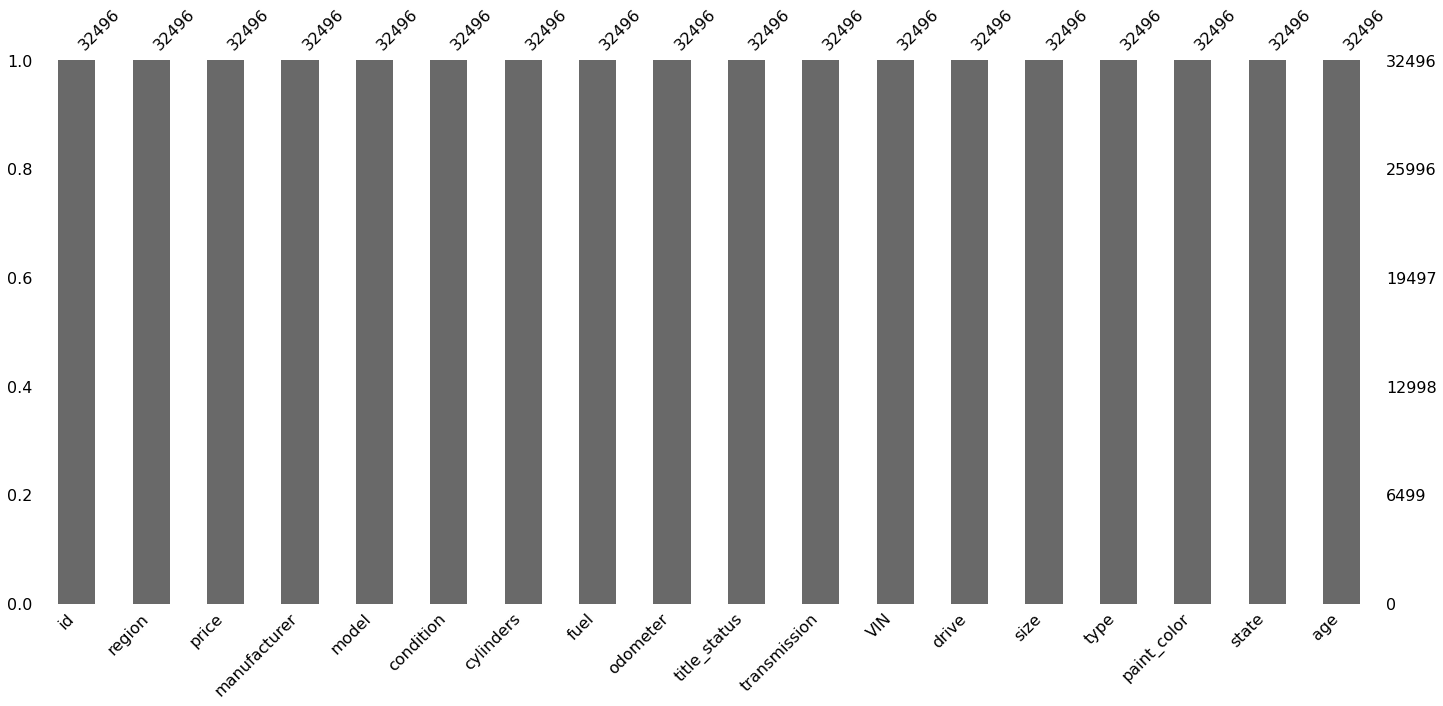

In [126]:

# Even though region has full values, don't see much correlation with price column
# used_cars['state_codes'] = pd.Categorical(used_cars.state).codes
# cols_to_drop = ['id']

# used_cars_clean = used_cars.drop(columns=cols_to_drop)
used_cars_clean = used_cars.dropna()
# used_cars_clean.head()
used_cars_clean.drop_duplicates(inplace=True)
used_cars_clean = used_cars_clean.reset_index().drop(columns=['index'])
used_cars_clean['age'] = 2022 - used_cars_clean.year.astype(int)
used_cars_clean.year = used_cars_clean.year.astype(int).astype(str)
used_cars_clean = used_cars_clean.drop(columns=['year'])
used_cars_clean.drop(used_cars_clean.query("price== 0").index,inplace=True)
msno.bar(used_cars_clean);

In [119]:
used_cars_clean.head()

,id,region,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state,state_codes,age
3,7316482063,birmingham,4000,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al,1,20
4,7316429417,birmingham,2500,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al,1,27
5,7315946365,birmingham,9000,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,JM1NC25F570128735,rwd,compact,convertible,white,al,1,14
6,7315354216,birmingham,8950,ford,f-150,excellent,6 cylinders,gas,164000.0,clean,automatic,1FTMF1CM6BKD55331,fwd,full-size,truck,white,al,1,11
7,7315349921,birmingham,4000,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,clean,automatic,1.14023E+13,rwd,full-size,coupe,silver,al,1,50


### Data Visualization: Plotting graphs to understand the price correlation with other columns by using 1000 sample

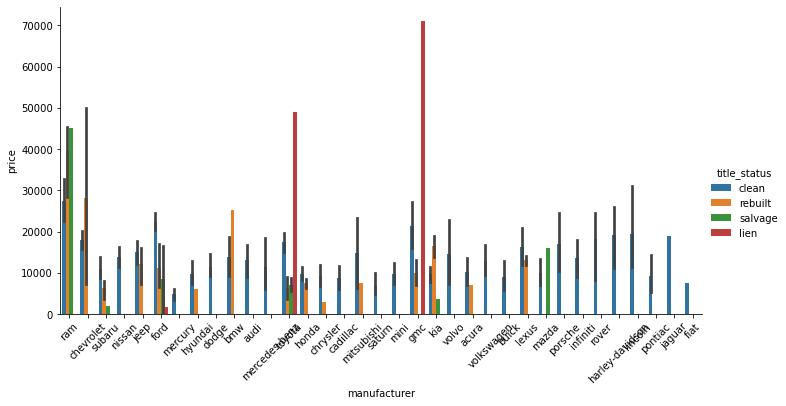

In [127]:
g = sns.catplot(x='manufacturer', y ='price', hue='title_status', data=used_cars_clean.sample(1000), 
            kind="bar", aspect=2, height=5)
g.set_xticklabels(rotation=45);

**Observation:** Clean title status car prices remain high

<Figure size 2160x576 with 0 Axes>

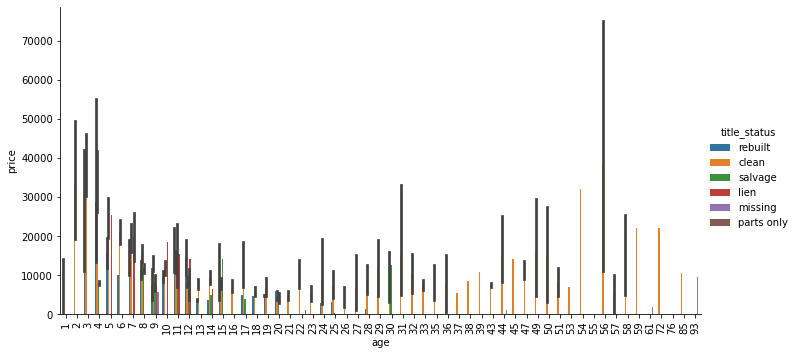

In [33]:
plt.figure(figsize=(30,8))
g = sns.catplot(x='age', y ='price', hue='title_status', data=used_cars_clean.sample(1000), 
            kind="bar", aspect=2, height=5)
g.set_xticklabels(rotation=90);

**Observation:** This is a known fact that recent year cars have high value then with a caveat vintage cars have high prices too.

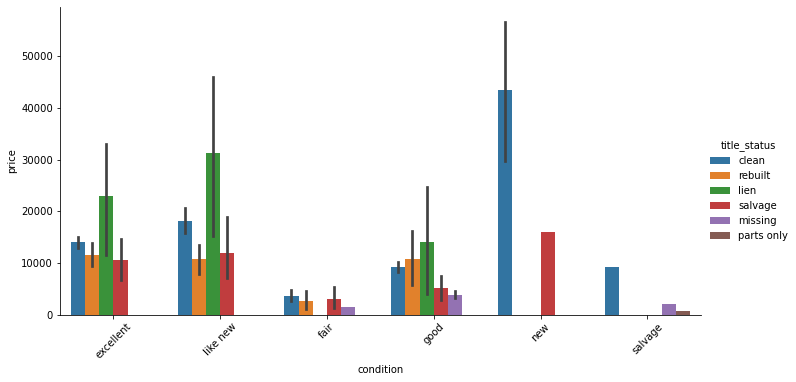

In [34]:
g = sns.catplot(x='condition', y ='price', hue='title_status', data=used_cars_clean.sample(1000), 
            kind="bar", aspect=2, height=5)
g.set_xticklabels(rotation=45);

**Observation:** It is obvious to note that prices are directly proportional to condition of cars

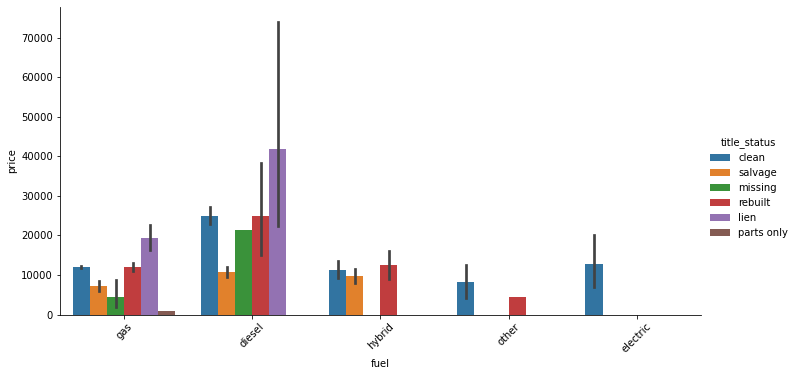

In [35]:
g = sns.catplot(x='fuel', y ='price', hue='title_status', data=used_cars_clean.sample(5000), 
            kind="bar", aspect=2, height=5)
g.set_xticklabels(rotation=45);

**Observation:** Fuel type has direct correlation to prices, Looks like Electric & Diesel cars are highly priced compared to others

### Transformation: Using LabelEncoder to transform non-numeric (Categorical) columns

In [113]:
encoders = []
def label_encode(cat_columns, df_enc):
    for c in cat_columns:
          le = LabelEncoder()
          encoders.append( le.fit(list(df_enc[c].astype(str).values)))
          df_enc[c] = le.transform(list(df_enc[c].astype(str).values))
            
def label_decode(df_enc):
    output = df_enc.copy()
    for col in cat_columns:
        output[col] = encoders[cat_columns.index(col)].inverse_transform(df_enc[col])
    return output

In [128]:
cat_columns = used_cars_clean.select_dtypes(exclude=np.number).columns.to_list()
print(f'Categorical columns: {cat_columns}\n\n')
used_cars_enc = used_cars_clean.copy()
label_encode(cat_columns,used_cars_enc)
used_cars_enc.head()

Categorical columns: ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'state']




,id,region,price,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state,age
3,7316482063,28,4000,38,1591,0,3,2,155000.0,0,0,17047,1,0,9,1,1,20
4,7316429417,28,2500,4,382,1,5,2,110661.0,0,0,19375,2,2,9,10,1,27
5,7315946365,28,9000,25,3094,0,3,2,56700.0,0,0,16472,2,0,2,10,1,14
6,7315354216,28,8950,13,1926,0,5,2,164000.0,0,0,3770,1,1,10,10,1,11
7,7315349921,28,4000,26,751,1,5,2,88100.0,0,0,8,2,1,3,9,1,50


In [129]:
print(used_cars_enc.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32496 entries, 3 to 34866
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            32496 non-null  int64  
 1   region        32496 non-null  int64  
 2   price         32496 non-null  int64  
 3   manufacturer  32496 non-null  int64  
 4   model         32496 non-null  int64  
 5   condition     32496 non-null  int64  
 6   cylinders     32496 non-null  int64  
 7   fuel          32496 non-null  int64  
 8   odometer      32496 non-null  float64
 9   title_status  32496 non-null  int64  
 10  transmission  32496 non-null  int64  
 11  VIN           32496 non-null  int64  
 12  drive         32496 non-null  int64  
 13  size          32496 non-null  int64  
 14  type          32496 non-null  int64  
 15  paint_color   32496 non-null  int64  
 16  state         32496 non-null  int64  
 17  age           32496 non-null  int64  
dtypes: float64(1), int64(17)
m

<AxesSubplot:xlabel='price', ylabel='Density'>

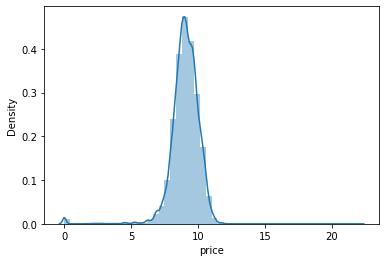

In [71]:
sns.distplot(np.log(used_cars_enc['price']))

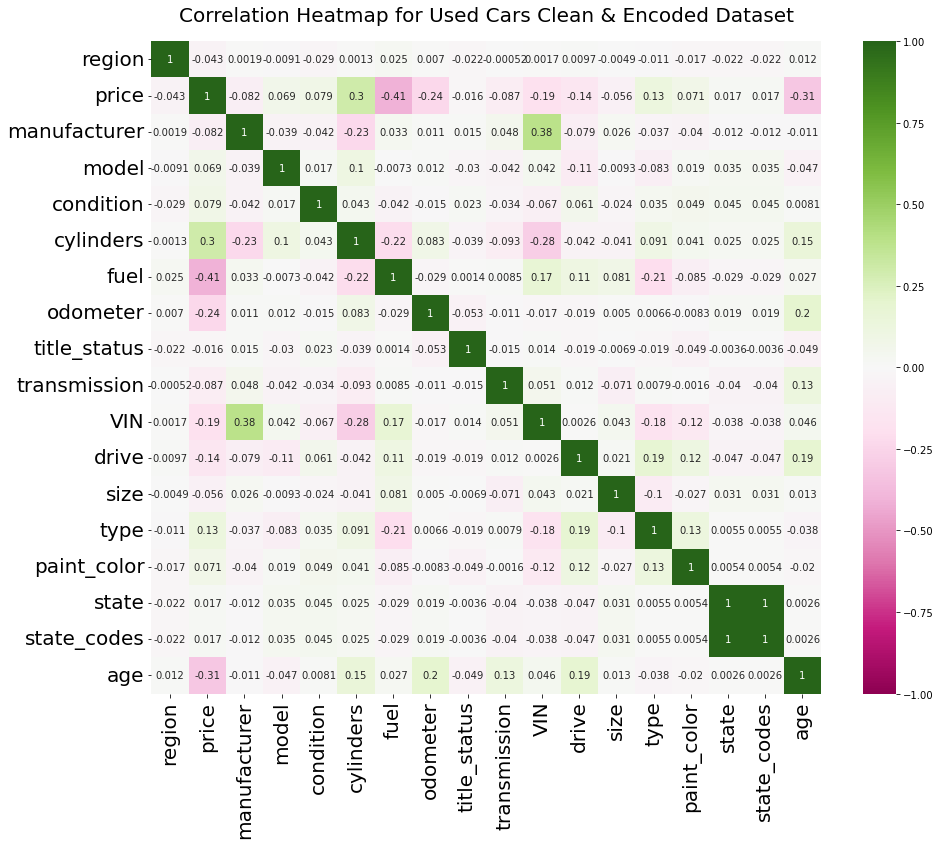

In [123]:
f, ax = plt.subplots(figsize=(15, 12))
ax.set_title('Correlation Heatmap for Used Cars Clean & Encoded Dataset', pad=20,fontsize = 20)
g = sns.heatmap(used_cars_enc.corr(), vmin=-1, vmax=1, annot=True, cmap='PiYG')
g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize = 20)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 20);

**Observation:** All selected feature colums are positively correlated with price and the ones with negative correlation are just south of 0. Will not be using Sequential feature selection.

### Prepare data for modeling: 
1.  Split encoded used cars dataframe to 70% training set & 30% test set
2.  Scaled data using Sandard Scaler

In [120]:
# Create X & target y sets
feature_cols = used_cars_enc.columns.values.tolist()
feature_cols.remove('price')

X = used_cars_enc[feature_cols]
y = used_cars_enc['price']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


# print(X_train.shape)
# print(y_test.shape)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

####  Use Different Regression Models
1. LinearRegression
2. Ridge
3. Lasso
4. Advanced ensamble Model such as RandomForestRegressor
4. Cross validate among the models 
5. Pick the most accurate model

In [121]:
# Create an ensamble method to select best fit model
def reg_model_metrics(reg_models, X_train, X_test, y_train, y_test):
    """ Function takes in different dictionary of models and training and testing sets, 
    and ouputs the below metrics in a dataframe:
    1. R² or Coefficient of Determination.
    2. Adjusted R²
    3. Mean Squared Error(MSE)
    4. Root-Mean-Squared-Error(RMSE).
    5. Mean-Absolute-Error(MAE).
    6. Model training and test scores or accuracies
    7. Plots graph between actual vs predicted datasets
    """
    
    R2_result         = []
    adj_R2_result     = []
    MSE_result        = []
    RMSE_result       = []
    MAE_result        = []
    str_models        = []
    training_score    = []
    testing_score     = []
    
    for model_name, model in reg_models.items():
        
        # Get predicted values on x_test
        pred_model = model.fit(X_train,y_train)
        y_pred = pred_model.predict(X_test)
        str_models.append(str(model_name))
        
        #1 & 2 Coefficient of Determination (R² & Adjusted R²)
        r2 = r2_score(y_test,y_pred)
        adj_r2 = 1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
        R2_result.append(round(r2, 2))
        adj_R2_result.append(round(adj_r2, 2))

        #3 & 4. MSE and RMSE
        mse = mean_squared_error(y_pred=y_pred, y_true=y_test, squared=True)
        rmse = mean_squared_error(y_pred=y_pred, y_true=y_test, squared=False)
        MSE_result.append(round(mse, 2))
        RMSE_result.append(round(rmse, 2))

        #5. MAE
        mae = mean_absolute_error(y_pred=y_pred, y_true=y_test)
        MAE_result.append(round(mae, 2))
    
        #6. Model training and test scores or accuracies
        train_score = round(pred_model.score(X_train, y_train)*100, 2)
        test_score = round(pred_model.score(X_test, y_test)*100, 2)
       
        training_score.append(train_score)
        testing_score.append(test_score)

        number_of_observations=50
        x_ax = range(len(y_test[:number_of_observations]))

        plt.figure(figsize=(16,8))
        plt.plot(x_ax, y_test[:number_of_observations], label="Actual")
        plt.plot(x_ax, y_pred[:number_of_observations], label="Predicted")
        plt.title("Used Car Prices: Predicted data - Actual using "+ str(model))
        plt.xlabel('Observation Number')
        plt.ylabel('Price')
        plt.xticks(np.arange(number_of_observations))
        plt.legend()
        plt.grid()
        plt.show();


    return pd.DataFrame({'models':str_models, 'R2':R2_result,'Adj_R2':adj_R2_result,'MSE':MSE_result,
                         'RMSE':RMSE_result,'MAE': MAE_result,
                         'Training_Score':training_score,
                         'Test_Score':testing_score
                        }) 


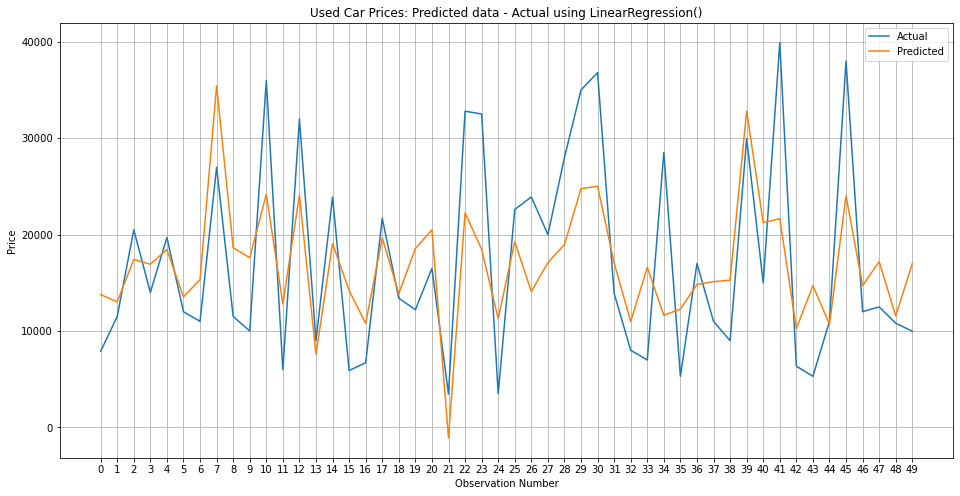

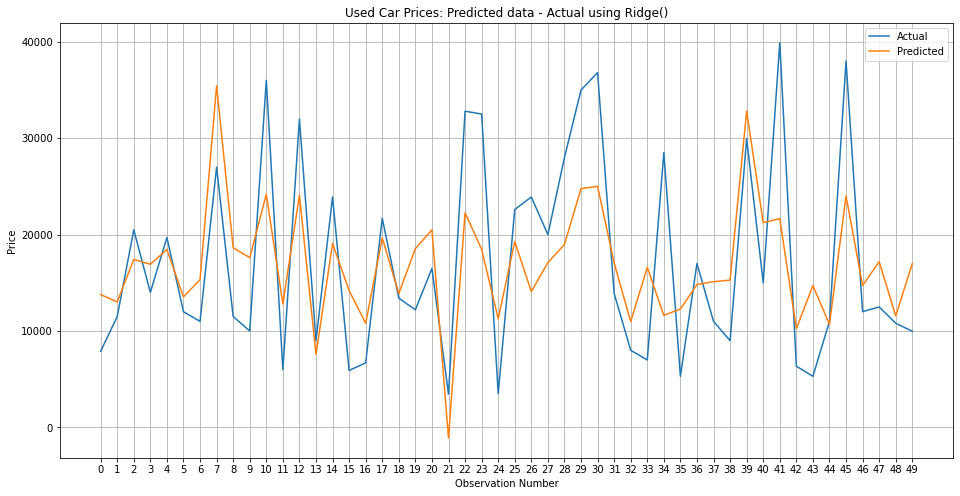

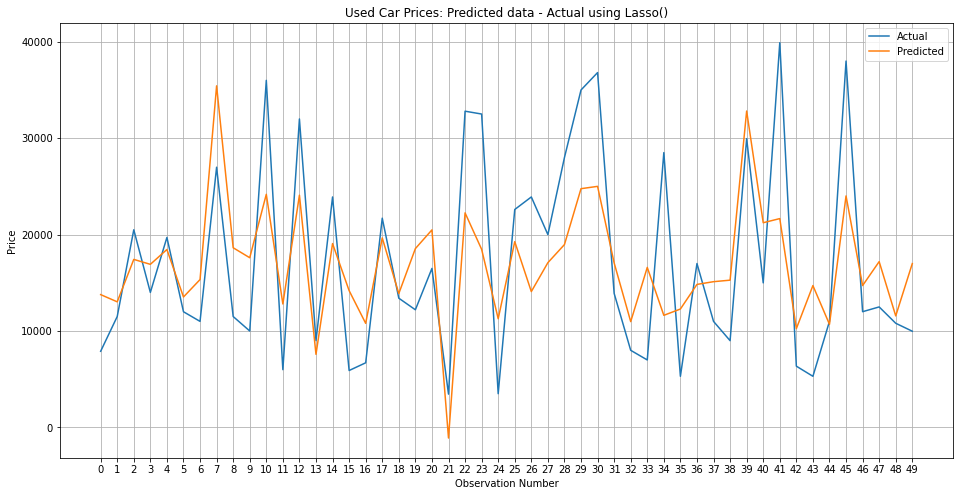

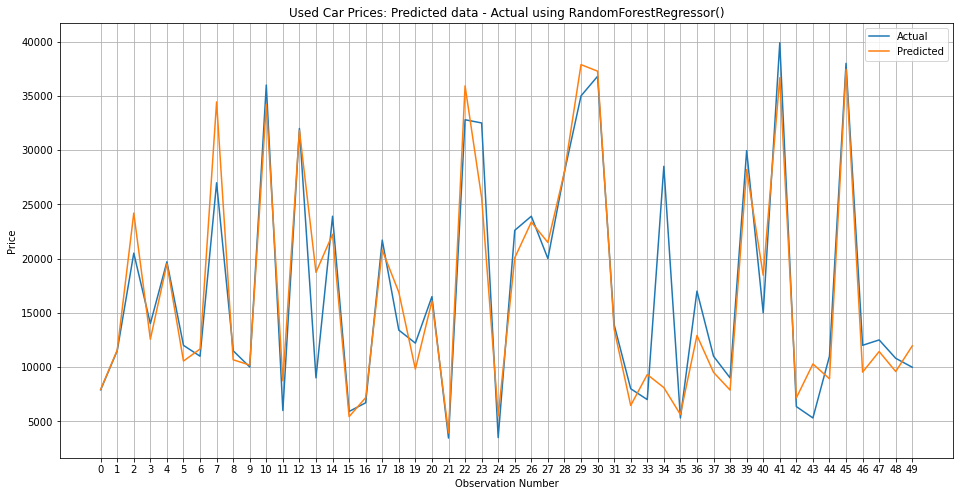

,models,R2,Adj_R2,MSE,RMSE,MAE,Training_Score,Test_Score
0,Linear Regression,0.38,0.38,1.084680e+08,10414.80,6811.51,38.34,38.25
1,Ridge,0.38,0.38,1.084673e+08,10414.76,6811.59,38.34,38.25
2,Lasso,0.38,0.38,1.084641e+08,10414.61,6811.94,38.34,38.25
3,RandomForestRegressor,0.87,0.87,2.325687e+07,4822.54,2499.56,97.77,86.76


In [122]:
regression_models={'Linear Regression':LinearRegression(), 'Ridge' : Ridge(), 'Lasso' : Lasso(),'RandomForestRegressor': RandomForestRegressor()}
reg_model_metrics(regression_models,X_train, X_test, y_train, y_test)

#### Observation: RandomForestRegressor got the highest training score, will be using this model for our prediction

## Warning: Tuning function takes longer time for RandomForestRegressor

In [86]:
def tuning_param(model, X_train, y_train, parameters):
        
    scores = []
   
    for parameter in parameters:
        
        gcv = GridSearchCV(estimator = model, param_grid = parameter, cv=5, scoring='r2')
        gcv.fit(X_train, y_train)

        for name_param, val_param in parameter.items():
            
            grid_mean_scores = gcv.cv_results_['mean_test_score']
            
            
        scores.append({'parameter':name_param,
                       'best_R2':gcv.best_score_,
                       'best_value':gcv.best_params_})
            

    return pd.DataFrame(scores, columns=['parameter', 'best_R2', 'best_value'])


In [492]:
# tuning_param(regression_models['RandomForestRegressor'], X_train, y_train,  [{'n_estimators': np.arange(100, 1000, 50)}])


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Predict and compare 10 random samples

In [136]:
def predict_price(used_cars_sample_df):
    """ Function takes in a sample dataframe from the clean dataset, 
    and transforms the feature columns 
    and ouputs the the predicted price array:"""
#     'region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status',
#     'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'state'
    x     = np.zeros(17)
    x[0]  = used_cars_sample_df['id'].values[0]
    x[1]  = encoders[cat_columns.index('region')].transform([used_cars_sample_df['region'].values[0]])
    x[2]  = encoders[cat_columns.index('manufacturer')].transform([used_cars_sample_df['manufacturer'].values[0]])
    x[3]  = encoders[cat_columns.index('model')].transform([used_cars_sample_df['model'].values[0]])
    x[4]  = encoders[cat_columns.index('condition')].transform([used_cars_sample_df['condition'].values[0]])
    x[5]  = encoders[cat_columns.index('cylinders')].transform([used_cars_sample_df['cylinders'].values[0]])
    x[6]  = encoders[cat_columns.index('fuel')].transform([used_cars_sample_df['fuel'].values[0]])
    x[7]  = used_cars_sample_df['odometer'].values[0]
    x[8]  = encoders[cat_columns.index('title_status')].transform([used_cars_sample_df['title_status'].values[0]])
    x[9]  = encoders[cat_columns.index('transmission')].transform([used_cars_sample_df['transmission'].values[0]])
    x[10]  = encoders[cat_columns.index('VIN')].transform([used_cars_sample_df['VIN'].values[0]])
    x[11]  = encoders[cat_columns.index('drive')].transform([used_cars_sample_df['drive'].values[0]])
    x[12]  = encoders[cat_columns.index('size')].transform([used_cars_sample_df['size'].values[0]])
    x[13] = encoders[cat_columns.index('type')].transform([used_cars_sample_df['type'].values[0]])
    x[14] = encoders[cat_columns.index('paint_color')].transform([used_cars_sample_df['paint_color'].values[0]])
    x[15] = encoders[cat_columns.index('state')].transform([used_cars_sample_df['state'].values[0]])
    x[16] = used_cars_sample_df['age'].values[0]
    
    x = scaler.transform([x])
    
    return regression_models['RandomForestRegressor'].predict(x)

In [134]:
sample_df = used_cars_clean.sample(1)
predicted_price = predict_price(sample_df)

for i in range(1,10):
    sample_df = used_cars_clean.sample(1)
    predicted_price = predict_price(sample_df)    
    print('************************************')
    print('Actual Price: ', sample_df['price'].values[0], 'Predicted Price: ',predicted_price[0])

************************************
Actual Price:  22599 Predicted Price:  23149.48
************************************
Actual Price:  11950 Predicted Price:  17500.455833333333
************************************
Actual Price:  7700 Predicted Price:  18109.28916666667
************************************
Actual Price:  17995 Predicted Price:  16112.2775
************************************
Actual Price:  19995 Predicted Price:  21974.71
************************************
Actual Price:  24995 Predicted Price:  27093.96
************************************
Actual Price:  13900 Predicted Price:  25535.77
************************************
Actual Price:  11785 Predicted Price:  28489.48
************************************
Actual Price:  4500 Predicted Price:  15558.960833333334


### **Observations:** 
 1.  **Above code snippet will take 10 different samples and predict and compare with actial price.**
 2.  **Model predictions are not accuarate, it needs more tuning.**
 3.  **I was unable to tune the RandomForestRegressor model Hyper parameters, GridSearchCv took longer time than expected.**

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

In [135]:
#  used_cars.query('price != 0').groupby(['manufacturer'])['price'].value_counts(sort=True,ascending=False).nlargest(10)
used_cars.query('price != 0 & year < 1970').groupby(['year'])['price'].agg(['mean', 'count']).sort_values(by='count',ascending=False).head()

,mean,count
year,,
1968.0,21206.774347,421
1966.0,48707.909976,411
1969.0,24531.019656,407
1965.0,363395.495845,361
1967.0,21998.458924,353


 ### Key Data Observations
 1. **Top 5 states that have maximum number of used car inventory are:**
    *  **California**
    *  **Florida**
    *  **Texas**
    *  **New York**
    *  **Ohio**
 2. **Top 5 manufacturer's cars in the used cars inventory are:**
    *  **Ford**
    *  **Chevrolet**
    *  **Toyota**
    *  **Honda**
    *  **Jeep**
 3. **Top priced used cars on an average are from these manufacturers:**
    *  **Mercedes-benz**
    *  **Volvo**
    *  **Toyota**
    *  **Jeep**
    *  **Ferrari**
 4. **According to the trend, these color cars were in the more demand:**
    *  **White - Avg price = 39k**
    *  **Black - Avg price = 46k**
    *  **Silver**
    *  **Blue**
    *  **Red**
 5.  **Clean status are sold high in number than rebuild,salvage,Lien & missing**
 6.  **SUV are sold more than any other type, second is pickups with high sold average price**
 7.  **As we all know, new cars or recent year cars have high prices and also Vintage cars**  

### Challenges:
1. **There were lots of missing vaues**
2. **Only known regression models were used**
3. **Data cleanisng was a challenge, there were cars with zero price which could be abandoned cars, these were removed for modelling purposes.**
4. **Unable to tune the models using GridSearchCV, for selected model it took very long time.**
5. **Current model is underfitting**



### Recommendations 

1.  **Current model is only 80% accuracte, Given an opportunity, I will train on many other ensable regression models**
2.  **Will also use VotingRegressor to pick the right regression model**
3.  **We can build a User Interface around this model and ask sales men to plugin values ask the model to pridict a price**
4.  **Business should be expanded based on the key data observations** 

### Conclusion

**Used Car Price recommendation/prediction system has been created and the underlying regression model has 80% score. 10 different samples from the given data is taken and comapered the actual price with the predicted price.**

**RandomForestRegressor model is used to create this system, in next iteration of this project, we can use most advanced ensemble models and also fine tune by using RandomizedSearchCV to obtain improved score and predictions.**